In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt;
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_cars = pd.read_csv("https://raw.githubusercontent.com/benvictoria17/MachineLearning/master/dataset/cars%20sales%20for%20time%20series%20prediction/sales-cars.csv")

In [3]:
df_cars.head()

,Month,Sales
0,2016-01,266
1,2016-02,146
2,2016-03,183
3,2016-04,119
4,2016-05,180


In [4]:
df_cars.index = pd.to_datetime(df_cars.Month, format='%Y-%m')
df_cars = df_cars.resample("M").sum()

In [5]:
df_cars.head()

,Sales
Month,
2016-01-31,266
2016-02-29,146
2016-03-31,183
2016-04-30,119
2016-05-31,180


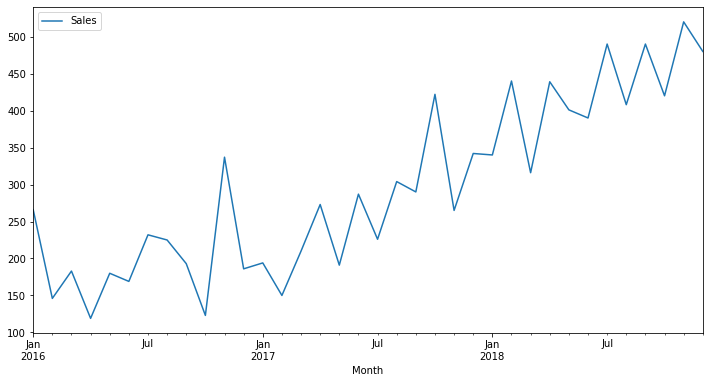

In [6]:
df_cars.plot(figsize=(12,6));

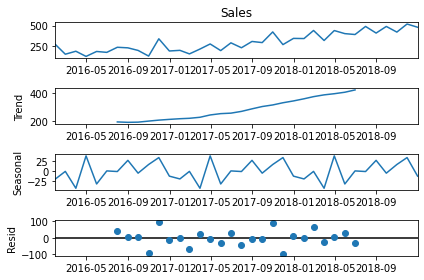

In [7]:
results = seasonal_decompose(df_cars['Sales'])
results.plot();

In [8]:
train = df_cars[:-6]
test = df_cars[-6:]

In [9]:
train.head()

,Sales
Month,
2016-01-31,266
2016-02-29,146
2016-03-31,183
2016-04-30,119
2016-05-31,180


In [10]:
test.head()

,Sales
Month,
2018-07-31,490
2018-08-31,408
2018-09-30,490
2018-10-31,420
2018-11-30,520


In [11]:
def generate_lag(df, n):
    X, y = [], []
    for i in range(len(df) - n):
        X.append(df[i:i+n])
        y.append(df[n+i])
    
    return np.array(X), np.array(y), np.array(y[-n:]).reshape(1,n)
X, y, last_batch_values = generate_lag(train.Sales.values, 12)
X

array([[266, 146, 183, 119, 180, 169, 232, 225, 193, 123, 337, 186],
       [146, 183, 119, 180, 169, 232, 225, 193, 123, 337, 186, 194],
       [183, 119, 180, 169, 232, 225, 193, 123, 337, 186, 194, 150],
       [119, 180, 169, 232, 225, 193, 123, 337, 186, 194, 150, 210],
       [180, 169, 232, 225, 193, 123, 337, 186, 194, 150, 210, 273],
       [169, 232, 225, 193, 123, 337, 186, 194, 150, 210, 273, 191],
       [232, 225, 193, 123, 337, 186, 194, 150, 210, 273, 191, 287],
       [225, 193, 123, 337, 186, 194, 150, 210, 273, 191, 287, 226],
       [193, 123, 337, 186, 194, 150, 210, 273, 191, 287, 226, 304],
       [123, 337, 186, 194, 150, 210, 273, 191, 287, 226, 304, 290],
       [337, 186, 194, 150, 210, 273, 191, 287, 226, 304, 290, 422],
       [186, 194, 150, 210, 273, 191, 287, 226, 304, 290, 422, 265],
       [194, 150, 210, 273, 191, 287, 226, 304, 290, 422, 265, 342],
       [150, 210, 273, 191, 287, 226, 304, 290, 422, 265, 342, 340],
       [210, 273, 191, 287, 226, 3

In [12]:
y

array([194, 150, 210, 273, 191, 287, 226, 304, 290, 422, 265, 342, 340,
       440, 316, 439, 401, 390])

In [13]:
last_batch_values

array([[226, 304, 290, 422, 265, 342, 340, 440, 316, 439, 401, 390]])

In [14]:
def mlp_model(input_, y_, epochs=1000):
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=input_.shape[1]))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    print(model.fit(input_, y_, epochs=epochs))
    return model
model = mlp_model(X,y, epochs=10)
model

2022-03-15 23:24:21.252539: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-03-15 23:24:21.420620: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
1/1 [==============================] - 1s 562ms/step - loss: 47575.6602
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 39418.8594
Epoch 3/10
1/1 [==============================] - 0s 4ms/step - loss: 32084.0664
Epoch 4/10
1/1 [==============================] - 0s 4ms/step - loss: 25572.4336
Epoch 5/10
1/1 [==============================] - 0s 4ms/step - loss: 19920.6133
Epoch 6/10
1/1 [==============================] - 0s 4ms/step - loss: 15167.3506
Epoch 7/10
1/1 [==============================] - 0s 3ms/step - loss: 11329.0078
Epoch 8/10
1/1 [==============================] - 0s 3ms/step - loss: 8347.6631
Epoch 9/10
1/1 [==============================] - 0s 4ms/step - loss: 6186.0210
Epoch 10/10
1/1 [==============================] - 0s 3ms/step - loss: 4753.0371


In [15]:
def forecast_function(model, last_batch, n):
    in_value = last_batch.copy()
    preds = []
    for i in range(n):
        p = model.predict(in_value)
        preds.append(p.ravel())
        in_value = np.append(in_value, p)[1:].reshape(last_batch.shape)
    return np.array(preds).ravel()
pred = forecast_function(model, last_batch_values, 6)
pred

array([421.4909 , 438.88547, 436.99408, 484.01947, 465.23712, 492.2877 ],
      dtype=float32)

In [16]:
test['Predicted_Sales']=pred
test.head()

,Sales,Predicted_Sales
Month,,
2018-07-31,490,421.490906
2018-08-31,408,438.885468
2018-09-30,490,436.994080
2018-10-31,420,484.019470
2018-11-30,520,465.237122


<AxesSubplot:xlabel='Month'>

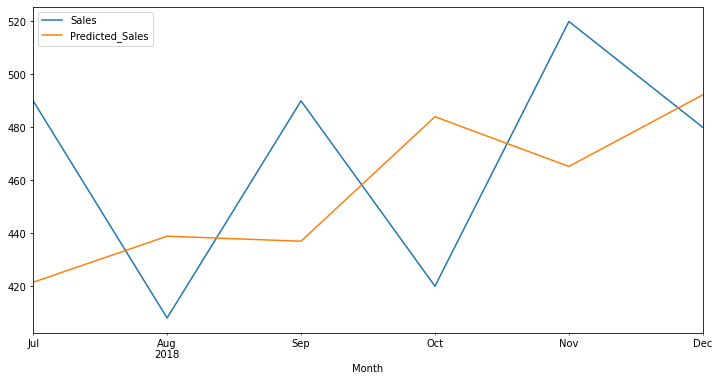

In [17]:
test.plot(figsize=(12,6))

In [18]:
def error_function(df,column_1,column_2):
    data = df.copy()
    my_list = []
    for i in range(len(data)):
        x = (data[column_2][i]*100)/data[column_1][i]
        if x >= 100:
            error = x-100
            #data['error_percentage'][i] = error
            my_list.append(error)
        else:
            error = 100-x
            my_list.append(error)
            #data['error_percentage'][i] = error
    data['error_percentage'] = my_list
    return data
column_1 = 'Sales'
column_2 = 'Predicted_Sales'
df_new = error_function(test,column_1,column_2)
df_new

,Sales,Predicted_Sales,error_percentage
Month,,,
2018-07-31,490,421.490906,13.981448
2018-08-31,408,438.885468,7.569968
2018-09-30,490,436.994080,10.817535
2018-10-31,420,484.019470,15.242731
2018-11-30,520,465.237122,10.531323
2018-12-31,480,492.287689,2.559935


In [19]:
def mean_error(df,error_column):
    total = 0
    for i in range(len(df)):
        total += df[error_column][i]
    mean_error_ = total/(len(df))
    return mean_error_
error_rate = mean_error(df_new,'error_percentage')
error_rate

10.117156523516078

In [20]:
sum_of_actual_sales = sum(df_new.Sales.values)
sum_of_actual_sales

2808

In [21]:
sum_of_predicted_sales = sum(df_new.Predicted_Sales.values)
sum_of_predicted_sales

2738.9147338867188

In [22]:
rate_of_actual_and_predict_sums = (sum_of_predicted_sales*100)/sum_of_actual_sales
if rate_of_actual_and_predict_sums >= 100:
    total_percentage = rate_of_actual_and_predict_sums - 100
else:
    total_percentage = 100-rate_of_actual_and_predict_sums
print('Percentage error: ',total_percentage)

Percentage error:  2.4603014997607318
